In [1]:
#To do lambdaの外部入力
using SparseIR
using PyPlot
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["font.size"] = 16
rcParams["text.latex.preamble"] = raw"\usepackage{amsmath}"
using LinearAlgebra
using Revise
using Optim
using FFTW
using Zygote
include("./src/Nevanlinna.jl")

Main.Nevanlinna

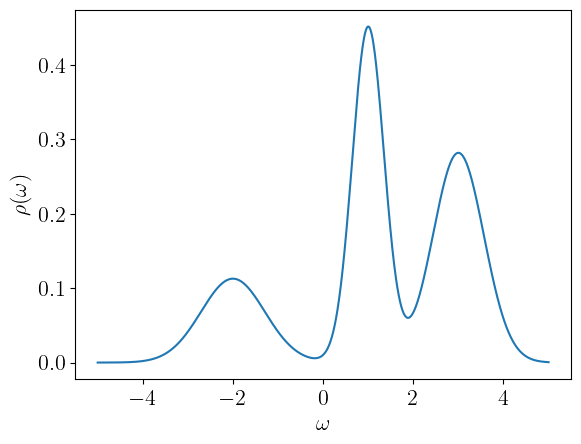

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f614c319070>

In [2]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)

#on-centered gaussian
#rho(omega) = gaussian(omega, 0.0, 0.15)  

#rho(omega) = gaussian(omega, 1.0, 0.15) +
#    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

rho(omega) = 0.4*gaussian(omega, 1.0, 0.5) + 
    0.4*gaussian(omega, 3.0, 0.8) + 0.2*gaussian(omega, -2.0, 1.0) 

######

#rho(omega) = 0.5*gaussian(omega, -3.0, 1.0) + 0.5*gaussian(omega, 3.0, 1.0) 

#off-centered gaussian
#rho(omega) = gaussian(omega, 0.2, 0.05) 

omegas = LinRange(-5, 5, 1000)
plt.xlabel(L"\omega")
plt.ylabel(L"\rho(\omega)")
plt.plot(omegas, rho.(omegas))

In [3]:
beta = 100
wmax = 1000
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) #もともと-7
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* rhol
;
#=
plt.semilogy(abs.(rhol), marker="o", label=L"|\rho_l|")
plt.semilogy(abs.(gl), marker="x", label=L"|g_l|")
plt.xlabel(L"l")
plt.ylim([1e-5, 1])
#plt.legend()
=#

In [4]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = Int64(length(IR_basis_set.smpl_wn_f.sampling_points)/2)

71

In [5]:
setprecision(128)
;

In [6]:
test_gw   = Array{Complex{BigFloat}}(undef, hnw) 
test_smpl = Array{BigFloat}(undef, hnw) 
;

In [7]:
for i in 1:hnw
    test_smpl[i]= parse(BigFloat, string(IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta))
    test_gw[i]  = parse(BigFloat, string(real(gw[hnw+i]))) + parse(BigFloat, string(imag(gw[hnw+i])))*im
end

In [8]:
N_real    =  6000
omega_max =  10.0
eta       =  0.001
H         =  8
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
#N_imag = 71
@time result    = Nevanlinna.Nevanlinna_Schur(N_imag, test_smpl, test_gw, N_real, omega_max, eta, H, true)
opt_real = result[2]
;

N_imag is setted as 31
Pick matrix is positive semi-definite.
Iter     Function value   Gradient norm 
     0     7.237505e-02     4.605309e-01
 * time: 0.06375813484191895
     1     2.837085e-02     2.013471e-01
 * time: 5.329612970352173
     2     2.330469e-02     1.766853e-01
 * time: 7.490983009338379
     3     7.865020e-03     5.782257e-02
 * time: 10.015172004699707
     4     3.653160e-03     2.095836e-02
 * time: 12.529154062271118
     5     2.742728e-03     2.130157e-02
 * time: 15.132412195205688
     6     1.987603e-03     2.869715e-02
 * time: 17.62949013710022
     7     6.651300e-04     9.668265e-03
 * time: 20.99649715423584
     8     3.576546e-04     3.587004e-03
 * time: 23.630226135253906
     9     2.971774e-04     3.425954e-03
 * time: 26.929870128631592
    10     2.573050e-04     1.704313e-03
 * time: 29.749783992767334
    11     2.213173e-04     2.948248e-03
 * time: 34.039889097213745
    12     2.045186e-04     7.062331e-04
 * time: 38.09185004234314
    

In [9]:
ab_coeff  = zeros(Complex{BigFloat}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(N_imag, test_smpl, test_gw)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta)

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H)

Nevanlinna.evaluation(raw_reals, abcd, H, ab_coeff, hardy_matrix)
;

Pick matrix is positive semi-definite.
max_theta=0.0
hardy optimization was success.


In [10]:
tmp =  sum(Float64.(imag.(opt_real.val))/pi)*((2.0*opt_real.omega_max)/opt_real.N_real)
abs(1-tmp)^2

5.469403926026219e-8

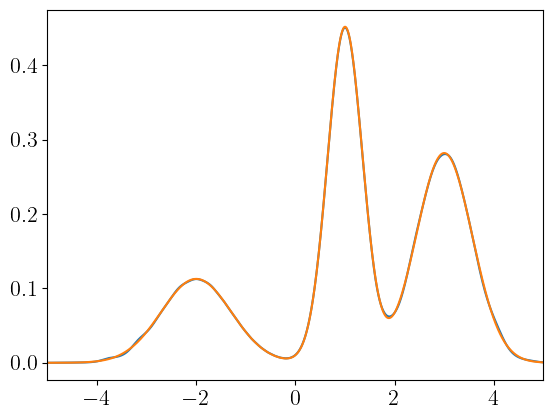

(-5.0, 5.0)

In [11]:
plt.plot(Float64.(real.((opt_real.freq))), Float64.(imag.(opt_real.val))/pi)
plt.plot(omegas, rho.(omegas))
#plt.plot(Float64.(real.((raw_reals.freq))), Float64.(imag.(raw_reals.val))/pi)
plt.xlim(-5,5)
#plt.ylim(0.0,50)

In [12]:
#=
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()
=#

In [13]:
#=
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
=#
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#